TensorFlow version:  2.1.0


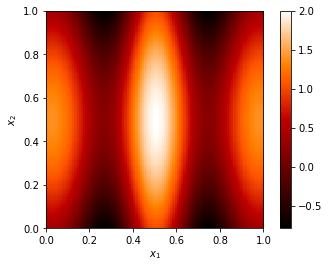

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
#from tensorflow.keras.layers import *
#from tensorflow.keras.models import *
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K

# Helper libraries
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt


# From the tutorial
# https://www.machinecurve.com/index.php/2020/02/18/how-to-use-k-fold-cross-validation-with-keras/
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold

from datetime import datetime
from packaging import version

print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."


def s3(x):
    
    "Activation function to implement the basis functions"
    
    y0 = K.switch(tf.logical_and(tf.zeros(tf.shape(x))<=x, x<tf.ones(tf.shape(x))), 
                 x**3/6, 
                 tf.zeros(tf.shape(x))
                )
    
    y1 = K.switch(tf.logical_and(tf.ones(tf.shape(x))<=x, x<2*tf.ones(tf.shape(x))),
                 (-3.*(x-1.)**3 +3.*(x-1.)**2 + 3*(x-1.)+1.)/6.,
                 tf.zeros(tf.shape(x))
                )
    
    y2 = K.switch(tf.logical_and(tf.ones(tf.shape(x))*2<=x, x<3*tf.ones(tf.shape(x))),
                 (3*(x-2)**3 - 6*(x-2)**2 + 4. )/6.,
                 tf.zeros(tf.shape(x))
                )

    y3 = K.switch(tf.logical_and(tf.ones(tf.shape(x))*3<=x, x<4*tf.ones(tf.shape(x))),
                 ( 4. -x)**3/6.,
                 tf.zeros(tf.shape(x))
                )    
    
    y  = y0 + y1 + y2 + y3
    
    return y

def partition_weights(n,n0):
    p0 = n0*n
    y = np.zeros((n,p0))
    for i in range(n):
        y[i,i*n0:(i+1)*n0] = 1.
    return y 

def partition_bias(n,n0):
    p0 = n0*n
    return (np.arange(0.,p0)%n0)    

def spline_function_(n,m,c0,u0):
    """
    Function from [0,1]^n to R^m
    n  - Input dimension
    m  - output dimension
    c0 - the capacity of the network, the number of control points for each input variable is proportional capacity
    u0 - the initial value of all control points
    """
    
    d0 = 3 
 
    n0 = c0 + d0 # the number of control points; capacity + degree of basis function
    p0 = n0*n

    w0 = tf.constant_initializer(c0*partition_weights(n,n0))
    b0 = tf.constant_initializer(d0 - partition_bias(n,n0))
    
    w1 = tf.constant_initializer(0.)

    inn = tf.keras.layers.Input(shape=(n,))

    l00 = tf.keras.layers.Dense(activation=s3,
                                units=p0,
                                use_bias=True,
                                trainable=False,
                                kernel_initializer=w0,
                                bias_initializer=b0 
                               )(inn)          # Modified
    
    out = tf.keras.layers.Dense(units=m,
                                use_bias=False,
                                trainable=True,
                                kernel_initializer=w1
                               )(l00)

    model = tf.keras.Model(inputs=inn, 
                           outputs= out
                          )
    return model

# Target function plot

def f(x,y):
    v0 = np.cos(4.*np.pi*x)*np.exp(-4*(x-0.5)**2) + np.sin(1.*np.pi*y)
    return v0

def f2(x,y):
    
    l0 = np.ones(x.shape)
    l1 = np.logical_and((x < 0.55*l0),(0.45*l0 < x ))
    l2 = np.logical_and((y < 0.55*l0),(0.45*l0 < y ))
    l3 = np.logical_and(l1,l2)
    
    v0 = f(x,y)*np.logical_not(l3) + 0.*l3
    
    return v0

resolution = 0.01

x0 = np.arange(0.,1., resolution)
x1 = np.arange(0.,1., resolution)

x0, x1 = np.meshgrid(x0, x1)
y0 = f(x0,x1)

img = plt.imshow(y0, interpolation='none', extent=[0.,1.,0.,1.])
#img.set_cmap('hot')
img.set_cmap('gist_heat')
plt.colorbar()
plt.xlabel(r'$x_{1}$')
plt.ylabel(r'$x_{2}$')

#plt.axis('off')
plt.show()

coordinates = np.array([x0.flatten(),x1.flatten()]).transpose()

2022-04-06 17:03:29.787580: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2022-04-06 17:03:29.792194: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2799925000 Hz
2022-04-06 17:03:29.792508: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5616ed486e10 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-04-06 17:03:29.792546: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-04-06 17:03:29.792624: I tensorflow/core/common_runtime/process_util.cc:147] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 128)               384       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 128       
Total params: 512
Trainable params: 128
Non-trainable params: 384
_________________________________________________________________


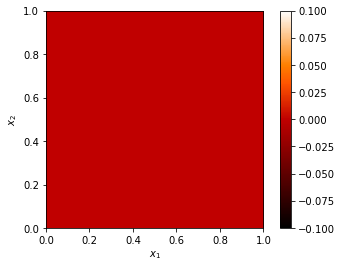

Train on 10000 samples
Epoch 1/15
10000/10000 [==============================] - 2s 157us/sample - loss: 0.5661 - mse: 0.5661
Epoch 2/15
10000/10000 [==============================] - 1s 74us/sample - loss: 0.2845 - mse: 0.2845
Epoch 3/15
10000/10000 [==============================] - 1s 100us/sample - loss: 0.1396 - mse: 0.1396
Epoch 4/15
10000/10000 [==============================] - 1s 94us/sample - loss: 0.0662 - mse: 0.0662
Epoch 5/15
10000/10000 [==============================] - 1s 84us/sample - loss: 0.0303 - mse: 0.0303
Epoch 6/15
10000/10000 [==============================] - 1s 88us/sample - loss: 0.0133 - mse: 0.0133
Epoch 7/15
10000/10000 [==============================] - 1s 91us/sample - loss: 0.0055 - mse: 0.0055
Epoch 8/15
10000/10000 [==============================] - 1s 103us/sample - loss: 0.0021 - mse: 0.0021
Epoch 9/15
10000/10000 [==============================] - 1s 82us/sample - loss: 7.3699e-04 - mse: 7.3699e-04
Epoch 10/15
10000/10000 [=======================

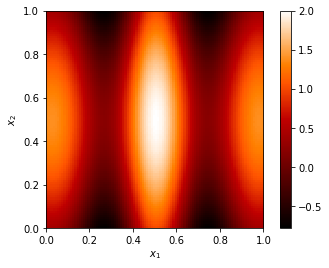

10000/10000 [==============================] - 1s 97us/sample - loss: 7.9125e-07 - mse: 7.9125e-07


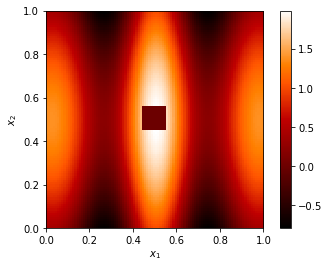

Train on 10000 samples
Epoch 1/10
10000/10000 [==============================] - 1s 88us/sample - loss: 1.0887 - mse: 1.0887
Epoch 2/10
10000/10000 [==============================] - 1s 91us/sample - loss: 0.0892 - mse: 0.0892
Epoch 3/10
10000/10000 [==============================] - 1s 85us/sample - loss: 0.0079 - mse: 0.0079
Epoch 4/10
10000/10000 [==============================] - 1s 103us/sample - loss: 8.3503e-04 - mse: 8.3503e-04
Epoch 5/10
10000/10000 [==============================] - 1s 90us/sample - loss: 1.7353e-04 - mse: 1.7353e-04
Epoch 6/10
10000/10000 [==============================] - 1s 87us/sample - loss: 5.7022e-05 - mse: 5.7022e-05
Epoch 7/10
10000/10000 [==============================] - 1s 98us/sample - loss: 2.6004e-05 - mse: 2.6004e-05
Epoch 8/10
10000/10000 [==============================] - 1s 88us/sample - loss: 1.5954e-05 - mse: 1.5954e-05
Epoch 9/10
10000/10000 [==============================] - 1s 93us/sample - loss: 1.1613e-05 - mse: 1.1613e-05
Epoch 10/1

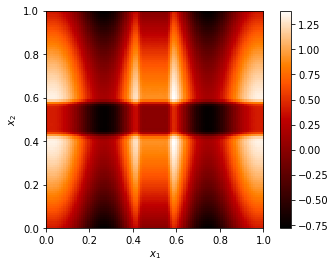

In [2]:
# Initialise a model

##################################################################################
# n,m,r,k,u0,h0
n   = 2
m   = 1
c0  = 61
u0  = 0.
model = spline_function_(n,m,c0,u0)

# Print model summary
model.summary()
##################################################################################

output1 = model.predict(coordinates).reshape(100,100)

##################################################################################
img = plt.imshow(output1, interpolation='none', extent=[0.,1.,0.,1.])
img.set_cmap('hot')
img.set_cmap('gist_heat')
#img.set_cmap('summer')
plt.colorbar()
plt.xlabel(r'$x_{1}$')
plt.ylabel(r'$x_{2}$')

#plt.axis('off')
plt.show()
##################################################################################

#########
#########
#########

# Data Generation 
##################################################################################
k = 10000

train_inputs = np.random.rand(k,2)
z0 = train_inputs[:,0]
z1 = train_inputs[:,1]
train_output = f(z0,z1)
##################################################################################

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss=tf.keras.losses.mean_squared_error,metrics=['mse'])

model.fit(train_inputs, train_output, epochs=15,verbose=1)

output2 = model.predict(coordinates).reshape(100,100)

##################################################################################
img = plt.imshow(output2, interpolation='none', extent=[0.,1.,0.,1.])
img.set_cmap('hot')
img.set_cmap('gist_heat')
#img.set_cmap('summer')
plt.colorbar()
plt.xlabel(r'$x_{1}$')
plt.ylabel(r'$x_{2}$')

#plt.axis('off')
plt.show()
##################################################################################

# Test on second task
##################################################################################
x_test1 = np.random.rand(k,2)
y_test1 = f(x_test1[:,0],x_test1[:,1])
results1 = model.evaluate(x_test1, y_test1)
##################################################################################

##########################
########################

##################################################################################

y_new = y0.copy()
y_new[44:55,44:55] = 0.

img = plt.imshow(y_new, interpolation='none', extent=[0.,1.,0.,1.])
#img.set_cmap('hot')
img.set_cmap('gist_heat')
plt.colorbar()
plt.xlabel(r'$x_{1}$')
plt.ylabel(r'$x_{2}$')

#plt.axis('off')
plt.show()

##################################################################################

train_inputs_2 = 0.11*np.random.rand(k,2)+0.44
train_output_2 = np.ones(k)*0.
model.fit(train_inputs_2, train_output_2, epochs=10,verbose=1)

##################################################################################

# Test on second task
##################################################################################
x_test2 = np.random.rand(k,2)
y_test2 = f2(x_test2[:,0],x_test2[:,1])
results2 = model.evaluate(x_test2, y_test2)
##################################################################################

output3 = model.predict(coordinates).reshape(100,100)

##################################################################################
img = plt.imshow(output3, interpolation='none', extent=[0.,1.,0.,1.])
img.set_cmap('hot')
img.set_cmap('gist_heat')
#img.set_cmap('summer')
plt.colorbar()
plt.xlabel(r'$x_{1}$')
plt.ylabel(r'$x_{2}$')

#plt.axis('off')
plt.show()
##################################################################################

In [3]:
task_1_results = []
task_2_results = []

for i in range(0,30):
    # Initialise a model

    ##################################################################################
    # n,m,r,k,u0,h0
    n   = 2
    m   = 1
    c0  = 61
    u0  = 0.
    model = spline_function_(n,m,c0,u0)

    output1 = model.predict(coordinates).reshape(100,100)

    # Data Generation 
    ##################################################################################
    k = 10000

    train_inputs = np.random.rand(k,2)
    z0 = train_inputs[:,0]
    z1 = train_inputs[:,1]
    train_output = f(z0,z1)

    ##################################################################################

    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
                  loss=tf.keras.losses.mean_squared_error,metrics=['mse'])

    model.fit(train_inputs, train_output, epochs=50,verbose=0)

    output2 = model.predict(coordinates).reshape(100,100)

    # Test on second task
    ##################################################################################
    x_test1 = np.random.rand(k,2)
    y_test1 = f(x_test1[:,0],x_test1[:,1])
    print("eval")
    results1 = model.evaluate(x_test1, y_test1)

    task_1_results.append(results1[-1])
    ##################################################################################

    y_new = y0.copy()
    y_new[44:55,44:55] = 0.

    ##################################################################################

    train_inputs_2 = 0.11*np.random.rand(k,2)+0.44
    train_output_2 = np.ones(k)*0.
    model.fit(train_inputs_2, train_output_2, epochs=10,verbose=0)

    ##################################################################################

    # Test on second task
    ##################################################################################
    x_test2 = np.random.rand(k,2)
    y_test2 = f2(x_test2[:,0],x_test2[:,1])
    print("evaluation")
    results2 = model.evaluate(x_test2, y_test2)

    task_2_results.append(results2[-1])
    ##################################################################################

    output3 = model.predict(coordinates).reshape(100,100)

    ##################################################################################

eval
10000/10000 [==============================] - 1s 90us/sample - loss: 1.3649e-06 - mse: 1.3649e-06
evaluation
10000/10000 [==============================] - 1s 67us/sample - loss: 0.2543 - mse: 0.2543
eval
10000/10000 [==============================] - 1s 95us/sample - loss: 8.1404e-07 - mse: 8.1404e-07
evaluation
10000/10000 [==============================] - 1s 81us/sample - loss: 0.2632 - mse: 0.2632
eval
10000/10000 [==============================] - 1s 100us/sample - loss: 7.1930e-07 - mse: 7.1930e-07
evaluation
10000/10000 [==============================] - 1s 66us/sample - loss: 0.2741 - mse: 0.2741
eval
10000/10000 [==============================] - 1s 106us/sample - loss: 3.2400e-07 - mse: 3.2400e-07
evaluation
10000/10000 [==============================] - 1s 70us/sample - loss: 0.2713 - mse: 0.2713
eval
10000/10000 [==============================] - 1s 113us/sample - loss: 3.0923e-07 - mse: 3.0923e-07
evaluation
10000/10000 [==============================] - 1s 90us/sam

In [6]:
task_1_results

[1.3648972e-06,
 8.140373e-07,
 7.193033e-07,
 3.2400064e-07,
 3.0922845e-07,
 4.5550334e-07,
 7.970159e-07,
 9.2029285e-07,
 2.2849137e-07,
 2.5946136e-07,
 8.388436e-07,
 9.171911e-07,
 5.7425393e-07,
 8.334729e-07,
 6.875174e-07,
 3.9176905e-07,
 3.0045663e-07,
 8.8309946e-07,
 1.274857e-06,
 4.565259e-07,
 2.3605591e-07,
 4.0528818e-08,
 1.3942689e-07,
 1.5028472e-06,
 1.2996483e-07,
 6.482906e-07,
 1.1047889e-06,
 1.1943622e-06,
 3.1901388e-06,
 6.355555e-07]

In [7]:
task_2_results

[0.25430134,
 0.26321068,
 0.27413145,
 0.27134544,
 0.26796234,
 0.2685881,
 0.27466935,
 0.26651436,
 0.27572986,
 0.27973753,
 0.26892778,
 0.27167654,
 0.27243438,
 0.27215108,
 0.27187535,
 0.26821336,
 0.27240968,
 0.26994735,
 0.275659,
 0.2760348,
 0.27319187,
 0.2657258,
 0.27585676,
 0.27483726,
 0.2725588,
 0.27215424,
 0.26423183,
 0.27227688,
 0.27032608,
 0.2686248]

In [10]:
np.array(task_1_results).mean()

7.390726e-07

In [12]:
np.array(task_1_results).std()

5.934575e-07

In [14]:
np.array(task_2_results).mean()

0.27084348

In [15]:
np.array(task_2_results).std()

0.0047996594

In [18]:
np.array(task_2_results).var()

2.303673e-05